In [4]:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np
import georasters as gr

In [5]:
vlm = pd.read_excel('data.xls')

In [6]:
file = 'Elevation.tif'
elevation = gr.from_file(file)

In [7]:
df = elevation.to_pandas()
df

,row,col,value,x,y
0,0,2347,1.0,54.651806,24.700139
1,0,2348,0.0,54.652084,24.700139
2,0,2349,1.0,54.652361,24.700139
3,0,2350,1.0,54.652639,24.700139
4,0,2351,2.0,54.652917,24.700139
...,...,...,...,...,...
1789656,1757,2516,37.0,54.698750,24.212083
1789657,1757,2517,36.0,54.699028,24.212083
1789658,1757,2518,37.0,54.699306,24.212083
1789659,1757,2519,38.0,54.699584,24.212083


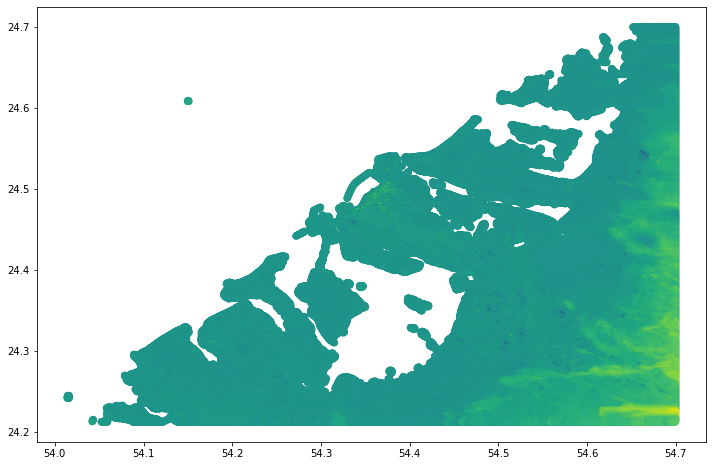

In [10]:
plt.figure(figsize=(12, 8))
plt.scatter(df.x, df.y, alpha=0.5, c=df.value)
plt.show()

### Numpy and scipy

In [11]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

In [23]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

In [21]:
grid_x.shape, grid_y.shape

((100, 200), (100, 200))

In [26]:
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])

In [29]:
points.shape, values.shape

((1000, 2), (1000,))

In [30]:
from scipy.interpolate import griddata

In [31]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')

In [33]:
grid_z0.shape

(100, 200)

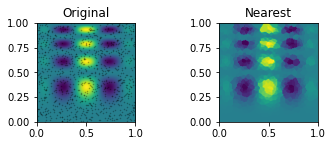

In [39]:
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1, alpha=0.3)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.show()

In [45]:
vlm_new = vlm.drop(columns=['Station', 'VLM_std'], axis=1)
vlm_new.head()

,Longitude,Latitude,VLM
0,54.684594,24.796595,-0.207
1,54.115618,24.303783,1.413
2,53.848164,24.056855,-0.856
3,53.141386,24.147625,-0.724
4,52.587928,24.171598,1.812


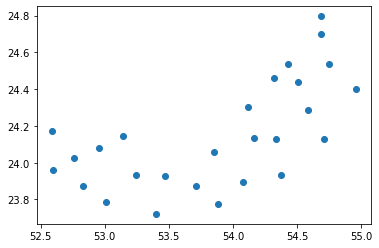

In [46]:
plt.scatter(vlm_new.Longitude, vlm_new.Latitude)

In [52]:
min_x, max_x = vlm_new.Longitude.min(), vlm_new.Longitude.max()
min_y, max_y = vlm_new.Latitude.min(), vlm_new.Latitude.max()

In [54]:
gridx, gridy = np.mgrid[min_x:max_x:1000j, min_y:max_y:1000j]

In [76]:
vlm_points = vlm_new[['Longitude', 'Latitude']].values
vlm_values = vlm_new.VLM.values

In [77]:
gridz0 = griddata(vlm_points, vlm_values, (gridx, gridy), method='nearest')

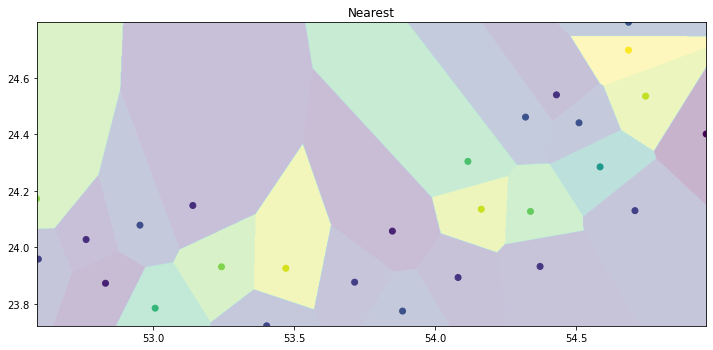

In [100]:
# plt.subplot(221)
# plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
# plt.plot(points[:,0], points[:,1], 'k.', ms=1, alpha=0.3)
# plt.title('Original')
# plt.subplot(222)
plt.figure(figsize=(12, 8))
plt.imshow(gridz0.T, extent=(min_x, max_x, min_y, max_y), origin='lower', alpha=0.3)
# plt.scatter(df.x, df.y, alpha=0.5, c=df.value)
plt.scatter(vlm_new.Longitude, vlm_new.Latitude, c=vlm_new.VLM)
plt.title('Nearest')
plt.show()

In [91]:
gridz0.min(), gridz0.max(), vlm_values.min(), vlm_values.max()

(-1.207, 2.471, -1.207, 2.471)

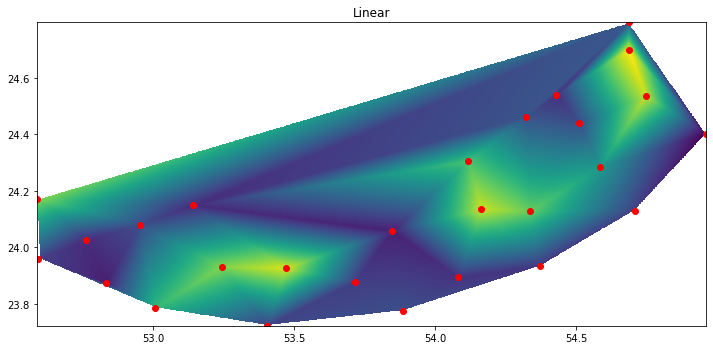

In [92]:
gridz1 = griddata(vlm_points, vlm_values, (gridx, gridy), method='linear')
plt.figure(figsize=(12, 8))
plt.imshow(gridz1.T, extent=(min_x, max_x, min_y, max_y), origin='lower')
plt.scatter(vlm_new.Longitude, vlm_new.Latitude, c='r')
plt.title('Linear')
plt.show()

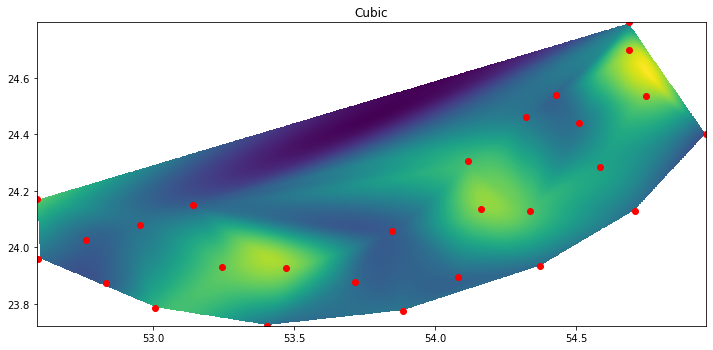

In [93]:
gridz2 = griddata(vlm_points, vlm_values, (gridx, gridy), method='cubic')
plt.figure(figsize=(12, 8))
plt.imshow(gridz2.T, extent=(min_x, max_x, min_y, max_y), origin='lower')
plt.scatter(vlm_new.Longitude, vlm_new.Latitude, c='r')
plt.title('Cubic')
plt.show()

In [95]:
gridx.shape, gridy.shape

((1000, 1000), (1000, 1000))

In [111]:
elev_coor = df[['x', 'y']].values

In [112]:
gridz3 = griddata(vlm_points, vlm_values, elev_coor, method='nearest')

In [114]:
gridz3.shape

(1789661,)

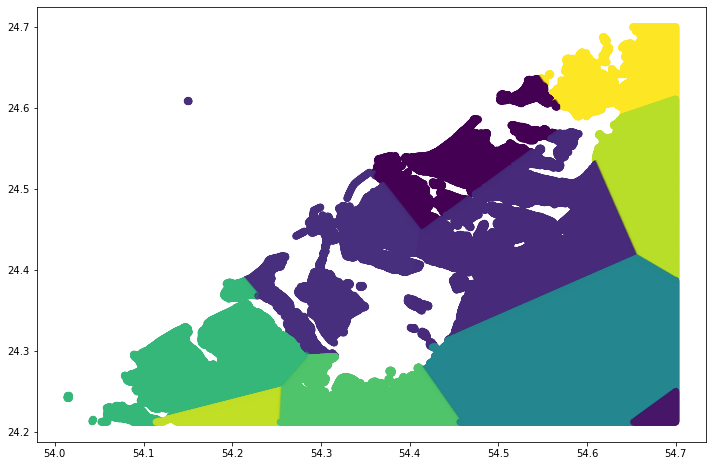

In [115]:
plt.figure(figsize=(12, 8))
plt.scatter(df.x, df.y, alpha=0.5, c=gridz3)
plt.show()

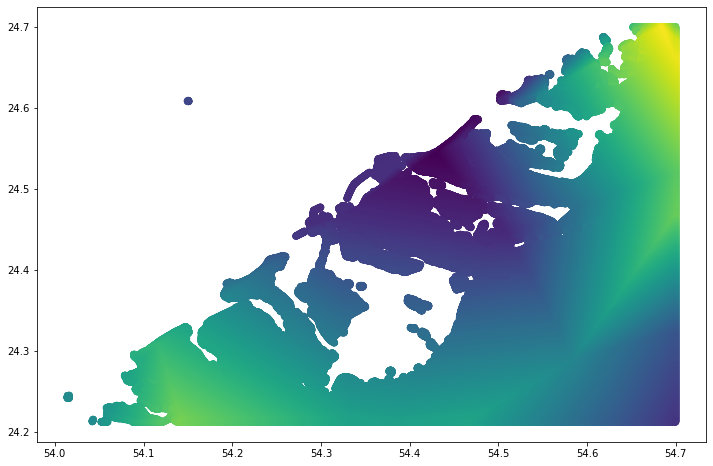

In [121]:
gridz4 = griddata(vlm_points, vlm_values, elev_coor, method='linear')
plt.figure(figsize=(12, 8))
plt.scatter(df.x, df.y, c=gridz4)
# plt.scatter(vlm_new.Longitude, vlm_new.Latitude, c=vlm_new.VLM)
plt.show()

In [122]:
elev_coor.shape

(1789661, 2)

In [127]:
slr = pd.read_excel('data.xls', sheet_name=1, skiprows=15)[['Scenario', 'RSL in 2030 (cm)',
                                                            'RSL in 2050 (cm)', 'RSL in 2080 (cm)', 'RSL in 2100 (cm)']]

In [136]:
slr_new = slr.loc[(slr.Scenario == '0.3 - LOW') |  (slr.Scenario == '2.5 - HIGH')]
slr_new

,Scenario,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm)
1,0.3 - LOW,10,15,21,22
17,2.5 - HIGH,55,114,241,357


In [161]:
slr_new['SL'] = slr_new.sum(axis=1)

<ipython-input-161-f034933f314d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slr_new['SL'] = slr_new.sum(axis=1)


In [171]:
slr_new

,Scenario,RSL in 2030 (cm),RSL in 2050 (cm),RSL in 2080 (cm),RSL in 2100 (cm),SL
1,0.3 - LOW,10,15,21,22,68
17,2.5 - HIGH,55,114,241,357,767


### Adjusted elevation = Initial land elevation - project sea level + VLM + uncertainties

In [138]:
gridz3.shape

(1789661,)

In [142]:
elev_values = df[['value']].values.flatten()

In [143]:
elev_values.shape

(1789661,)

In [151]:
a = np.array((1, 2, 3))
b = np.array((4, 5, 6))
a + b

array([5, 7, 9])

Note: gridz3 currently has interpolated VLM values with <code>nearest</code> method

#### <code>LOW</code> scenario

In [172]:
ae_low = elev_values - slr_new.iloc[0].SL + gridz3

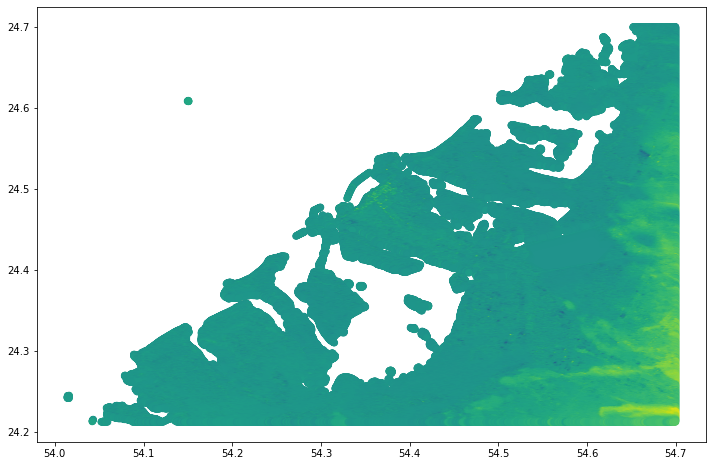

In [175]:
plt.figure(figsize=(12, 8))
plt.scatter(df.x, df.y, alpha=0.5, c=ae_low)
plt.show()

In [176]:
ae_low.min(), ae_low.max()

(-156.237, 14.763)

#### <code>HIGH</code> scenario

In [177]:
ae_high = elev_values - slr_new.iloc[1].SL + gridz3

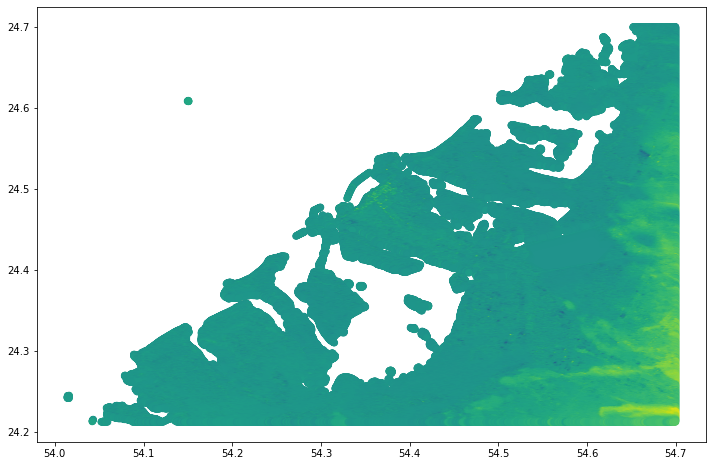

In [178]:
plt.figure(figsize=(12, 8))
plt.scatter(df.x, df.y, alpha=0.5, c=ae_high)
plt.show()

In [179]:
ae_high.min(), ae_high.max()

(-855.237, -684.237)

<Figure size 864x720 with 0 Axes>

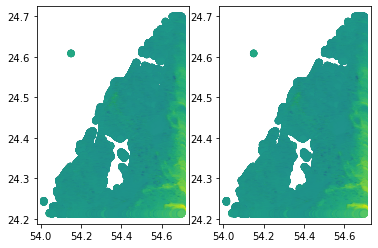

In [180]:
plt.figure(figsize=(12, 10))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(df.x, df.y, alpha=0.5, c=ae_low)
ax2.scatter(df.x, df.y, alpha=0.5, c=ae_high)
plt.show()